In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 16000, 32)    192         input_4[0][0]                    
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 16000, 32)    0           conv1d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 5333, 32)     0           activation_12[0][0]              
__________________________________________________________________________________________________
conv1d_13 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 16000, 32)    192         input_6[0][0]                    
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 16000, 32)    0           conv1d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_25 (MaxPooling1D) (None, 5333, 32)     0           activation_25[0][0]              
__________________________________________________________________________________________________
conv1d_26 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1502 - acc: 0.3295
Epoch 00001: val_loss improved from inf to 1.74915, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_3_conv_checkpoint/001-1.7492.hdf5
36805/36805 [==============================] - 23s 624us/sample - loss: 2.1502 - acc: 0.3295 - val_loss: 1.7492 - val_acc: 0.4708
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5548 - acc: 0.5204
Epoch 00002: val_loss improved from 1.74915 to 1.56127, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_3_conv_checkpoint/002-1.5613.hdf5
36805/36805 [==============================] - 20s 550us/sample - loss: 1.5548 - acc: 0.5203 - val_loss: 1.5613 - val_acc: 0.5027
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3276 - acc: 0.5904
Epoch 00003: val_loss improved from 1

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2065 - acc: 0.9440
Epoch 00028: val_loss did not improve from 1.45568
36805/36805 [==============================] - 21s 561us/sample - loss: 0.2065 - acc: 0.9440 - val_loss: 1.8331 - val_acc: 0.5812
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1991 - acc: 0.9455
Epoch 00029: val_loss did not improve from 1.45568
36805/36805 [==============================] - 21s 563us/sample - loss: 0.1991 - acc: 0.9455 - val_loss: 1.8355 - val_acc: 0.5893
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1894 - acc: 0.9490
Epoch 00030: val_loss did not improve from 1.45568
36805/36805 [==============================] - 21s 561us/sample - loss: 0.1895 - acc: 0.9490 - val_loss: 1.8710 - val_acc: 0.5886
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1775 - acc: 0.9540
Epoch 00031: val_loss did not improve from 1.45568
36805/36805 [=====

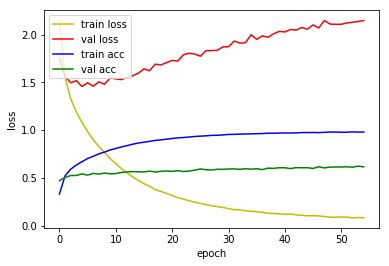

4815/4815 [==============================] - 1s 307us/sample - loss: 1.5206 - acc: 0.5225
Loss: 1.5206209133223458 Accuracy: 0.5225338

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1309 - acc: 0.3220
Epoch 00001: val_loss improved from inf to 1.67315, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_4_conv_checkpoint/001-1.6732.hdf5
36805/36805 [==============================] - 19s 529us/sample - loss: 2.1308 - acc: 0.3220 - val_loss: 1.6732 - val_acc: 0.4815
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5725 - acc: 0.5084
Epoch 00002: val_loss improved from 1.67315 to 1.50189, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_4_conv_checkpoint/002-1.5019.hdf5
36805/36805 [==============================] - 18s 501us/sample - loss: 1.5725 - acc: 0.5084 - val_loss: 1.5019 - val_acc: 0.5337
Epoch 3/500
36800/36805 [====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3466 - acc: 0.8902
Epoch 00026: val_loss did not improve from 1.20112
36805/36805 [==============================] - 18s 497us/sample - loss: 0.3466 - acc: 0.8902 - val_loss: 1.2935 - val_acc: 0.6599
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3337 - acc: 0.8938
Epoch 00027: val_loss did not improve from 1.20112
36805/36805 [==============================] - 18s 498us/sample - loss: 0.3337 - acc: 0.8938 - val_loss: 1.2715 - val_acc: 0.6692
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3211 - acc: 0.8993
Epoch 00028: val_loss did not improve from 1.20112
36805/36805 [==============================] - 18s 496us/sample - loss: 0.3211 - acc: 0.8993 - val_loss: 1.2790 - val_acc: 0.6702
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3029 - acc: 0.9049
Epoch 00029: val_loss did not improve from 1.20112
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9593
Epoch 00056: val_loss did not improve from 1.20112
36805/36805 [==============================] - 18s 497us/sample - loss: 0.1325 - acc: 0.9593 - val_loss: 1.4741 - val_acc: 0.7091
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9611
Epoch 00057: val_loss did not improve from 1.20112
36805/36805 [==============================] - 18s 497us/sample - loss: 0.1278 - acc: 0.9611 - val_loss: 1.4849 - val_acc: 0.7028
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1288 - acc: 0.9605
Epoch 00058: val_loss did not improve from 1.20112
36805/36805 [==============================] - 18s 499us/sample - loss: 0.1288 - acc: 0.9605 - val_loss: 1.4799 - val_acc: 0.7095
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1274 - acc: 0.9609
Epoch 00059: val_loss did not improve from 1.20112
36805/36805 [=====

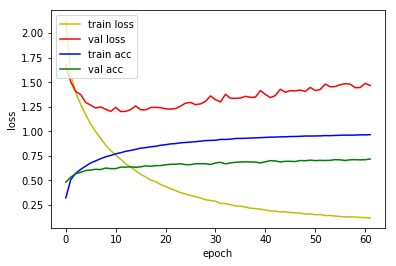

4815/4815 [==============================] - 2s 320us/sample - loss: 1.2618 - acc: 0.6098
Loss: 1.2618204119297078 Accuracy: 0.6097612

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2028 - acc: 0.2942
Epoch 00001: val_loss improved from inf to 1.74812, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_5_conv_checkpoint/001-1.7481.hdf5
36805/36805 [==============================] - 21s 570us/sample - loss: 2.2028 - acc: 0.2942 - val_loss: 1.7481 - val_acc: 0.4531
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6340 - acc: 0.4821
Epoch 00002: val_loss improved from 1.74812 to 1.53352, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_5_conv_checkpoint/002-1.5335.hdf5
36805/36805 [==============================] - 18s 500us/sample - loss: 1.6340 - acc: 0.4821 - val_loss: 1.5335 - val_acc: 0.5052
Epoch 3/500
36800/36805 [====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5453 - acc: 0.8346
Epoch 00023: val_loss improved from 0.80104 to 0.78833, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_5_conv_checkpoint/023-0.7883.hdf5
36805/36805 [==============================] - 18s 492us/sample - loss: 0.5453 - acc: 0.8346 - val_loss: 0.7883 - val_acc: 0.7710
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5292 - acc: 0.8381
Epoch 00024: val_loss did not improve from 0.78833
36805/36805 [==============================] - 18s 484us/sample - loss: 0.5292 - acc: 0.8381 - val_loss: 0.8033 - val_acc: 0.7692
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5083 - acc: 0.8442
Epoch 00025: val_loss improved from 0.78833 to 0.76875, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_5_conv_checkpoint/025-0.7687.hdf5
36805/36805 [==============================] - 18s 490us/sample - loss: 0.50

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2335 - acc: 0.9262
Epoch 00049: val_loss did not improve from 0.71507
36805/36805 [==============================] - 18s 485us/sample - loss: 0.2335 - acc: 0.9262 - val_loss: 0.7246 - val_acc: 0.8097
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2282 - acc: 0.9275
Epoch 00050: val_loss did not improve from 0.71507
36805/36805 [==============================] - 18s 485us/sample - loss: 0.2282 - acc: 0.9275 - val_loss: 0.7433 - val_acc: 0.8120
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2223 - acc: 0.9304
Epoch 00051: val_loss did not improve from 0.71507
36805/36805 [==============================] - 18s 487us/sample - loss: 0.2223 - acc: 0.9304 - val_loss: 0.7402 - val_acc: 0.8109
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2204 - acc: 0.9301
Epoch 00052: val_loss did not improve from 0.71507
36805/36805 [=====

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9585
Epoch 00079: val_loss did not improve from 0.71507
36805/36805 [==============================] - 18s 484us/sample - loss: 0.1263 - acc: 0.9585 - val_loss: 0.7319 - val_acc: 0.8341
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1258 - acc: 0.9597
Epoch 00080: val_loss did not improve from 0.71507
36805/36805 [==============================] - 18s 484us/sample - loss: 0.1258 - acc: 0.9597 - val_loss: 0.7323 - val_acc: 0.8376
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1218 - acc: 0.9607
Epoch 00081: val_loss did not improve from 0.71507
36805/36805 [==============================] - 18s 488us/sample - loss: 0.1218 - acc: 0.9607 - val_loss: 0.7536 - val_acc: 0.8381
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1211 - acc: 0.9602
Epoch 00082: val_loss did not improve from 0.71507
36805/36805 [=====

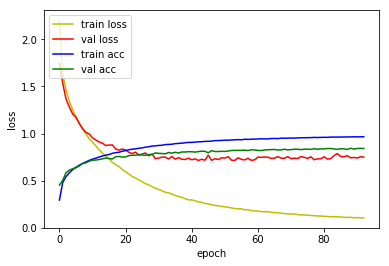

4815/4815 [==============================] - 1s 307us/sample - loss: 0.8005 - acc: 0.7838
Loss: 0.8005222551052692 Accuracy: 0.7838006

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2863 - acc: 0.2633
Epoch 00001: val_loss improved from inf to 1.64088, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_6_conv_checkpoint/001-1.6409.hdf5
36805/36805 [==============================] - 21s 581us/sample - loss: 2.2862 - acc: 0.2633 - val_loss: 1.6409 - val_acc: 0.4864
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5909 - acc: 0.4913
Epoch 00002: val_loss improved from 1.64088 to 1.39654, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_6_conv_checkpoint/002-1.3965.hdf5
36805/36805 [==============================] - 18s 498us/sample - loss: 1.5909 - acc: 0.4912 - val_loss: 1.3965 - val_acc: 0.5670
Epoch 3/500
36800/36805 [====================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4827 - acc: 0.8531
Epoch 00022: val_loss did not improve from 0.46696
36805/36805 [==============================] - 18s 498us/sample - loss: 0.4827 - acc: 0.8530 - val_loss: 0.4720 - val_acc: 0.8682
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4647 - acc: 0.8582
Epoch 00023: val_loss improved from 0.46696 to 0.45590, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_6_conv_checkpoint/023-0.4559.hdf5
36805/36805 [==============================] - 18s 496us/sample - loss: 0.4647 - acc: 0.8582 - val_loss: 0.4559 - val_acc: 0.8686
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4467 - acc: 0.8631
Epoch 00024: val_loss improved from 0.45590 to 0.45116, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_6_conv_checkpoint/024-0.4512.hdf5
36805/36805 [==============================] - 18s 494us/sample - loss: 0.44

36800/36805 [============================>.] - ETA: 0s - loss: 0.2436 - acc: 0.9226
Epoch 00046: val_loss did not improve from 0.34083
36805/36805 [==============================] - 18s 499us/sample - loss: 0.2435 - acc: 0.9226 - val_loss: 0.3468 - val_acc: 0.9057
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2363 - acc: 0.9241
Epoch 00047: val_loss improved from 0.34083 to 0.32737, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_6_conv_checkpoint/047-0.3274.hdf5
36805/36805 [==============================] - 18s 497us/sample - loss: 0.2363 - acc: 0.9241 - val_loss: 0.3274 - val_acc: 0.9110
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2357 - acc: 0.9250
Epoch 00048: val_loss did not improve from 0.32737
36805/36805 [==============================] - 18s 500us/sample - loss: 0.2358 - acc: 0.9249 - val_loss: 0.3393 - val_acc: 0.9085
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1432 - acc: 0.9521
Epoch 00074: val_loss did not improve from 0.32002
36805/36805 [==============================] - 18s 495us/sample - loss: 0.1431 - acc: 0.9522 - val_loss: 0.3320 - val_acc: 0.9180
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1398 - acc: 0.9536
Epoch 00075: val_loss did not improve from 0.32002
36805/36805 [==============================] - 18s 493us/sample - loss: 0.1398 - acc: 0.9536 - val_loss: 0.3439 - val_acc: 0.9092
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9533
Epoch 00076: val_loss did not improve from 0.32002
36805/36805 [==============================] - 18s 497us/sample - loss: 0.1421 - acc: 0.9533 - val_loss: 0.3266 - val_acc: 0.9150
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9530
Epoch 00077: val_loss did not improve from 0.32002
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0978 - acc: 0.9675
Epoch 00102: val_loss did not improve from 0.31331
36805/36805 [==============================] - 18s 495us/sample - loss: 0.0977 - acc: 0.9675 - val_loss: 0.3396 - val_acc: 0.9201
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0953 - acc: 0.9685
Epoch 00103: val_loss did not improve from 0.31331
36805/36805 [==============================] - 18s 496us/sample - loss: 0.0953 - acc: 0.9685 - val_loss: 0.3301 - val_acc: 0.9222
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9679
Epoch 00104: val_loss did not improve from 0.31331
36805/36805 [==============================] - 18s 496us/sample - loss: 0.0924 - acc: 0.9679 - val_loss: 0.3402 - val_acc: 0.9217
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0910 - acc: 0.9698
Epoch 00105: val_loss did not improve from 0.31331
36805/36805 [===============

Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9751
Epoch 00132: val_loss did not improve from 0.31331
36805/36805 [==============================] - 18s 495us/sample - loss: 0.0744 - acc: 0.9751 - val_loss: 0.3403 - val_acc: 0.9252
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9774
Epoch 00133: val_loss did not improve from 0.31331
36805/36805 [==============================] - 18s 497us/sample - loss: 0.0702 - acc: 0.9774 - val_loss: 0.3444 - val_acc: 0.9236
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0704 - acc: 0.9768
Epoch 00134: val_loss did not improve from 0.31331
36805/36805 [==============================] - 18s 493us/sample - loss: 0.0703 - acc: 0.9768 - val_loss: 0.3532 - val_acc: 0.9269
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9769
Epoch 00135: val_loss did not improve from 0.31331
36805/36805 [=

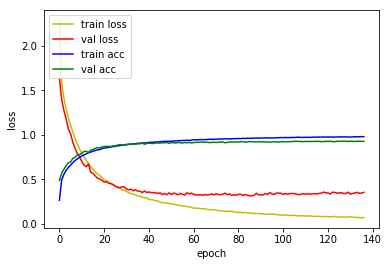

4815/4815 [==============================] - 1s 293us/sample - loss: 0.4121 - acc: 0.8947
Loss: 0.41212150227986394 Accuracy: 0.89470404

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3553 - acc: 0.2211
Epoch 00001: val_loss improved from inf to 1.80643, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_7_conv_checkpoint/001-1.8064.hdf5
36805/36805 [==============================] - 23s 618us/sample - loss: 2.3553 - acc: 0.2211 - val_loss: 1.8064 - val_acc: 0.4330
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6498 - acc: 0.4599
Epoch 00002: val_loss improved from 1.80643 to 1.32759, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_7_conv_checkpoint/002-1.3276.hdf5
36805/36805 [==============================] - 19s 527us/sample - loss: 1.6500 - acc: 0.4599 - val_loss: 1.3276 - val_acc: 0.5973
Epoch 3/500
36800/36805 [==================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4078 - acc: 0.8733
Epoch 00022: val_loss improved from 0.32835 to 0.32151, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_7_conv_checkpoint/022-0.3215.hdf5
36805/36805 [==============================] - 19s 523us/sample - loss: 0.4078 - acc: 0.8733 - val_loss: 0.3215 - val_acc: 0.9066
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3947 - acc: 0.8770
Epoch 00023: val_loss improved from 0.32151 to 0.31073, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_7_conv_checkpoint/023-0.3107.hdf5
36805/36805 [==============================] - 20s 530us/sample - loss: 0.3947 - acc: 0.8770 - val_loss: 0.3107 - val_acc: 0.9054
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3855 - acc: 0.8794
Epoch 00024: val_loss improved from 0.31073 to 0.30046, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2166 - acc: 0.9303
Epoch 00045: val_loss did not improve from 0.19572
36805/36805 [==============================] - 19s 525us/sample - loss: 0.2166 - acc: 0.9303 - val_loss: 0.1966 - val_acc: 0.9441
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2150 - acc: 0.9311
Epoch 00046: val_loss did not improve from 0.19572
36805/36805 [==============================] - 19s 525us/sample - loss: 0.2150 - acc: 0.9312 - val_loss: 0.2007 - val_acc: 0.9415
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2158 - acc: 0.9304
Epoch 00047: val_loss did not improve from 0.19572
36805/36805 [==============================] - 19s 521us/sample - loss: 0.2158 - acc: 0.9304 - val_loss: 0.2047 - val_acc: 0.9401
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2104 - acc: 0.9328
Epoch 00048: val_loss did not improve from 0.19572
36805/36805 [=====

Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1354 - acc: 0.9554
Epoch 00072: val_loss improved from 0.17187 to 0.17075, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_7_conv_checkpoint/072-0.1707.hdf5
36805/36805 [==============================] - 19s 517us/sample - loss: 0.1354 - acc: 0.9554 - val_loss: 0.1707 - val_acc: 0.9518
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1370 - acc: 0.9552
Epoch 00073: val_loss did not improve from 0.17075
36805/36805 [==============================] - 19s 516us/sample - loss: 0.1370 - acc: 0.9553 - val_loss: 0.1777 - val_acc: 0.9495
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1355 - acc: 0.9558- ETA: 0s - loss: 0.1355 - acc: 0.9
Epoch 00074: val_loss did not improve from 0.17075
36805/36805 [==============================] - 19s 521us/sample - loss: 0.1355 - acc: 0.9557 - val_loss: 0.1726 - val_acc: 0.9497
Epoch 75/500
36800/36

Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9659
Epoch 00099: val_loss did not improve from 0.16674
36805/36805 [==============================] - 19s 528us/sample - loss: 0.0977 - acc: 0.9659 - val_loss: 0.1840 - val_acc: 0.9453
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0951 - acc: 0.9670
Epoch 00100: val_loss did not improve from 0.16674
36805/36805 [==============================] - 20s 532us/sample - loss: 0.0951 - acc: 0.9670 - val_loss: 0.1740 - val_acc: 0.9511
Epoch 101/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9689
Epoch 00101: val_loss did not improve from 0.16674
36805/36805 [==============================] - 19s 519us/sample - loss: 0.0942 - acc: 0.9689 - val_loss: 0.1722 - val_acc: 0.9513
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9688
Epoch 00102: val_loss did not improve from 0.16674
36805/36805 [==

Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9773
Epoch 00129: val_loss did not improve from 0.16674
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0670 - acc: 0.9773 - val_loss: 0.1708 - val_acc: 0.9555
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0667 - acc: 0.9772
Epoch 00130: val_loss did not improve from 0.16674
36805/36805 [==============================] - 19s 524us/sample - loss: 0.0666 - acc: 0.9772 - val_loss: 0.1868 - val_acc: 0.9515
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9771- ETA: 
Epoch 00131: val_loss did not improve from 0.16674
36805/36805 [==============================] - 19s 527us/sample - loss: 0.0668 - acc: 0.9771 - val_loss: 0.2022 - val_acc: 0.9515
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9778
Epoch 00132: val_loss did not improve from 0.16674
36805/3

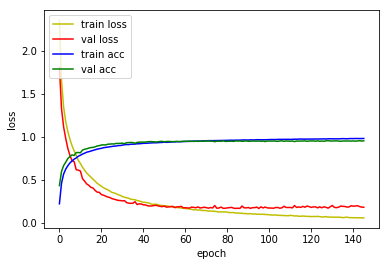

4815/4815 [==============================] - 2s 354us/sample - loss: 0.2453 - acc: 0.9354
Loss: 0.24532797088999367 Accuracy: 0.9354102

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4545 - acc: 0.1988
Epoch 00001: val_loss improved from inf to 1.73326, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_8_conv_checkpoint/001-1.7333.hdf5
36805/36805 [==============================] - 25s 681us/sample - loss: 2.4545 - acc: 0.1988 - val_loss: 1.7333 - val_acc: 0.4689
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6270 - acc: 0.4626
Epoch 00002: val_loss improved from 1.73326 to 1.27598, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_8_conv_checkpoint/002-1.2760.hdf5
36805/36805 [==============================] - 20s 536us/sample - loss: 1.6270 - acc: 0.4626 - val_loss: 1.2760 - val_acc: 0.5980
Epoch 3/500
36800/36805 [===================

36736/36805 [============================>.] - ETA: 0s - loss: 0.3492 - acc: 0.8890
Epoch 00022: val_loss improved from 0.28348 to 0.26432, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_8_conv_checkpoint/022-0.2643.hdf5
36805/36805 [==============================] - 20s 535us/sample - loss: 0.3489 - acc: 0.8891 - val_loss: 0.2643 - val_acc: 0.9187
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3357 - acc: 0.8937
Epoch 00023: val_loss did not improve from 0.26432
36805/36805 [==============================] - 20s 531us/sample - loss: 0.3357 - acc: 0.8937 - val_loss: 0.2652 - val_acc: 0.9159
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3223 - acc: 0.8970
Epoch 00024: val_loss improved from 0.26432 to 0.24506, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_8_conv_checkpoint/024-0.2451.hdf5
36805/36805 [==============================] - 20s 535us/sample - loss: 0.3223 - acc: 0.8

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1764 - acc: 0.9427
Epoch 00047: val_loss did not improve from 0.17775
36805/36805 [==============================] - 20s 530us/sample - loss: 0.1765 - acc: 0.9427 - val_loss: 0.1863 - val_acc: 0.9422
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1723 - acc: 0.9436
Epoch 00048: val_loss improved from 0.17775 to 0.17184, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_8_conv_checkpoint/048-0.1718.hdf5
36805/36805 [==============================] - 20s 540us/sample - loss: 0.1723 - acc: 0.9436 - val_loss: 0.1718 - val_acc: 0.9474
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1700 - acc: 0.9443
Epoch 00049: val_loss did not improve from 0.17184
36805/36805 [==============================] - 20s 537us/sample - loss: 0.1699 - acc: 0.9443 - val_loss: 0.1815 - val_acc: 0.9436
Epoch 50/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9630
Epoch 00074: val_loss did not improve from 0.16693
36805/36805 [==============================] - 19s 526us/sample - loss: 0.1076 - acc: 0.9630 - val_loss: 0.1715 - val_acc: 0.9525
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1034 - acc: 0.9643
Epoch 00075: val_loss did not improve from 0.16693
36805/36805 [==============================] - 19s 512us/sample - loss: 0.1034 - acc: 0.9643 - val_loss: 0.1817 - val_acc: 0.9499
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9640
Epoch 00076: val_loss did not improve from 0.16693
36805/36805 [==============================] - 19s 508us/sample - loss: 0.1038 - acc: 0.9640 - val_loss: 0.1778 - val_acc: 0.9504
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1008 - acc: 0.9655
Epoch 00077: val_loss did not improve from 0.16693
36805/36805 [==================

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9766
Epoch 00104: val_loss did not improve from 0.16693
36805/36805 [==============================] - 19s 516us/sample - loss: 0.0670 - acc: 0.9766 - val_loss: 0.1828 - val_acc: 0.9574
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.9776
Epoch 00105: val_loss did not improve from 0.16693
36805/36805 [==============================] - 19s 510us/sample - loss: 0.0642 - acc: 0.9776 - val_loss: 0.1903 - val_acc: 0.9527
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9760
Epoch 00106: val_loss did not improve from 0.16693
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0696 - acc: 0.9760 - val_loss: 0.1855 - val_acc: 0.9532
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0643 - acc: 0.9777
Epoch 00107: val_loss did not improve from 0.16693
36805/36805 [=

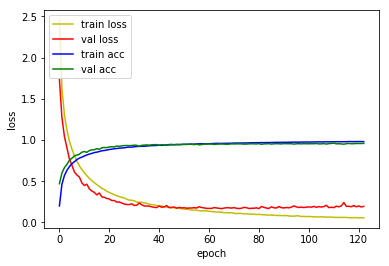

4815/4815 [==============================] - 2s 348us/sample - loss: 0.2225 - acc: 0.9360
Loss: 0.22245212425076455 Accuracy: 0.93603325



In [10]:
base = '1D_CNN_custom_multi_3_concat_ch_32_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
_________________________________________________________

4815/4815 [==============================] - 2s 316us/sample - loss: 1.2618 - acc: 0.6098
Loss: 1.2618204119297078 Accuracy: 0.6097612

1D_CNN_custom_multi_3_concat_ch_32_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 32)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (Max

4815/4815 [==============================] - 2s 329us/sample - loss: 0.4121 - acc: 0.8947
Loss: 0.41212150227986394 Accuracy: 0.89470404

1D_CNN_custom_multi_3_concat_ch_32_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 32)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (M

4815/4815 [==============================] - 2s 388us/sample - loss: 0.2225 - acc: 0.9360
Loss: 0.22245212425076455 Accuracy: 0.93603325


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_concat_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
_________________________________________________________

4815/4815 [==============================] - 2s 380us/sample - loss: 1.6199 - acc: 0.6783
Loss: 1.6198623078882013 Accuracy: 0.678297

1D_CNN_custom_multi_3_concat_ch_32_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 32)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxP

4815/4815 [==============================] - 2s 385us/sample - loss: 0.4516 - acc: 0.9065
Loss: 0.45163340688308823 Accuracy: 0.90654206

1D_CNN_custom_multi_3_concat_ch_32_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 32)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (M

4815/4815 [==============================] - 2s 411us/sample - loss: 0.2591 - acc: 0.9398
Loss: 0.2591033273775939 Accuracy: 0.93977153
